https://pytorch-lightning.readthedocs.io/en/stable/notebooks/course_UvA-DL/08-deep-autoencoders.html

## data generation

In [3]:
data_dir = '/scratch/projects/023/01_data/synthetic/001'
annotations_file = '/scratch/projects/023/01_data/synthetic/001/annotations.csv'

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

import torch
import torchvision
import cv2
from torchvision.transforms.functional import rotate, center_crop, resize
from albumentations import ElasticTransform, Compose, Blur
from albumentations.augmentations.geometric import functional as albu_geom
from albumentations.pytorch import ToTensorV2
import albumentations as A
import json

In [5]:
anns = pd.read_csv(annotations_file)
anns.sample(10)
# anns['model'].value_counts()

,filename,model,sampling_t,span,value_min,white_fraction,period,img_filename,idx
23673,strips_23673_001_model-23_100.npy,001_model-23,100,0.159386,0.156021,0.409990,9.176259,strips_23673_001_model-23_100.png,23673
58842,strips_58842_005_model-11_80.npy,005_model-11,80,0.150612,0.157819,0.517837,28.089051,strips_58842_005_model-11_80.png,58842
19036,strips_19036_001_model-23_80.npy,001_model-23,80,0.197958,0.176466,0.351348,22.127441,strips_19036_001_model-23_80.png,19036
72527,strips_72527_005_model-11_120.npy,005_model-11,120,0.158563,0.125392,0.288816,14.090163,strips_72527_005_model-11_120.png,72527
2124,strips_2124_001_model-23_60.npy,001_model-23,60,0.146263,0.156402,0.573566,10.496710,strips_2124_001_model-23_60.png,2124
33471,strips_33471_001_model-23_120.npy,001_model-23,120,0.298936,0.150124,0.560298,29.649071,strips_33471_001_model-23_120.png,33471
71829,strips_71829_005_model-11_120.npy,005_model-11,120,0.246294,0.132893,0.327433,16.022726,strips_71829_005_model-11_120.png,71829
33783,strips_33783_001_model-23_120.npy,001_model-23,120,0.126590,0.160859,0.423440,12.179957,strips_33783_001_model-23_120.png,33783
28447,strips_28447_001_model-23_100.npy,001_model-23,100,0.157432,0.173915,0.536931,15.494692,strips_28447_001_model-23_100.png,28447
27650,strips_27650_001_model-23_100.npy,001_model-23,100,0.148214,0.179719,0.290262,27.280326,strips_27650_001_model-23_100.png,27650


In [6]:
class StripsDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, data_root='', transforms=[]):
        if isinstance(annotations, Path) or isinstance(annotations, str):
            self.annotations = pd.read_csv(annotations)
        else:
            self.annotations = annotations
        self.data_root = Path(data_root)
        self.transforms = transforms
    
    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        image_data = {
            'image': cv2.imread(str(self.data_root / row['img_filename']), cv2.IMREAD_GRAYSCALE),
            'period': row['period'],
            'white_fraction': row['white_fraction'],
            'direction': 0.
        }

        for transform in self.transforms:
            image_data = transform(**image_data)
        
        return {
            'image': image_data['image'], 
            'period':  torch.tensor(image_data['period'], dtype=torch.float32), 
            'white_fraction':  torch.tensor(image_data['white_fraction'], dtype=torch.float32),
            'direction': torch.tensor(image_data['direction'], dtype=torch.float32)
            }

    def __len__(self):
        return len(self.annotations)

{'image': array([[56, 60, 64, ..., 40, 59, 46],
       [62, 64, 58, ..., 43, 36, 37],
       [58, 60, 43, ..., 42, 42, 45],
       ...,
       [55, 70, 60, ..., 32, 35, 47],
       [63, 57, 62, ..., 24, 38, 43],
       [63, 57, 63, ..., 36, 27, 46]], dtype=uint8), 'period': tensor(9.2177), 'white_fraction': tensor(0.2900), 'direction': tensor(0.)}


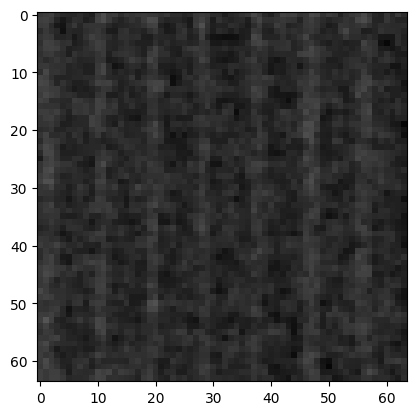

In [7]:
ds_raw = StripsDataset(annotations_file, data_dir)
image_data = ds_raw[200]
plt.imshow(image_data['image'], vmin=0, vmax=255, cmap='gray')
print(image_data)

In [8]:
class ReadImage:
  def __init__(self, mode=None, target_label='image_path', image_label='image'):
    self.read_mode = mode
    self.target_label = target_label
    self.image_label = image_label
  def __call__(self, **kwargs):
    kwargs[self.image_label] = cv2.imread(kwargs[self.target_label], self.read_mode)
    return kwargs

class RandomResizeTransform:
  def __init__(self, scale_range, target_label='scale'):
    self.scale_range = scale_range
    self.target_label = target_label
  def __call__(self, image, **kwargs):
    scale = np.exp(np.random.uniform(*np.log(self.scale_range)))
    kwargs['image'] = albu_geom.scale(image, scale)
    kwargs[self.target_label] = kwargs[self.target_label]*scale
    return kwargs
  def __repr__(self) -> str:
     return f'RandomResizeTransform({self.scale_range}, {self.target_label})'

class ResizeToTransform:
  def __init__(self, size, target_label='scale'):
    self.size = size
    self.target_label = target_label
  def __call__(self, image, **kwargs):
    scale = self.size/max(image.shape)
    kwargs['image'] = albu_geom.longest_max_size(image, max_size=self.size, interpolation=cv2.INTER_LINEAR)
    kwargs[self.target_label] = kwargs[self.target_label]*scale
    return kwargs
  def __repr__(self) -> str:
     return f'ResizeToTransform({self.size}, {self.target_label})'

class RotateTransform:
  def __init__(self, rotation_range, target_label='rotation', transform_kwargs={}):
    self.rotation_range = rotation_range
    self.target_label = target_label
    self.transform_kwargs = transform_kwargs
  def __call__(self, image, **kwargs):
    rotation = np.random.uniform(*self.rotation_range)
    kwargs['image'] = albu_geom.rotate(image, rotation, **self.transform_kwargs)
    kwargs[self.target_label] = (kwargs[self.target_label] + rotation + 90) % 180  - 90#TODO spr +/-
    return kwargs
  def __repr__(self) -> str:
     return f'RotateTransform({self.rotation_range}, {self.target_label}, {self.transform_kwargs})'

class HorizontalFlipTransform:
  def __init__(self, p=0.5, target_label='rotation', transform_kwargs={}):
    self.p = p
    self.target_label = target_label
  def __call__(self, image, **kwargs):
    apply_transform = np.random.rand() <= self.p
    if apply_transform:
      kwargs['image'] = np.ascontiguousarray(image[:, ::-1, ...])
      kwargs[self.target_label] = -kwargs[self.target_label]
    else:
      kwargs['image'] = image
    return kwargs
  def __repr__(self) -> str:
     return f'HorizontalFlipTransform({self.p}, {self.target_label})'

## Data pipeline

In [1]:
transforms_config = {
    'crop_size': 64,
    'normalization': {'mean': 0.3, 'std': 0.2},
    'train_resize_range': [0.7, 1.5], #[0.8, 1.25]
    'test_resize_range': [1., 1.],
    'equalize': False,
    'blur_test': True,
    'superpixel': False,
    'CLAHE': False,
    'train_PixelDropout': False
}

In [20]:
crop_size = transforms_config['crop_size']
normalization = transforms_config['normalization']

train_transforms = [
    # ReadImage(mode=cv2.IMREAD_GRAYSCALE), 
    ResizeToTransform(96, 'period'),
    RandomResizeTransform(transforms_config['train_resize_range'], 'period'), 
    A.GaussianBlur(blur_limit=(5,7), sigma_limit=(0.1, 0.5), p=1),
    A.PadIfNeeded(min_height=crop_size, min_width=crop_size, border_mode=cv2.BORDER_CONSTANT, value=normalization['mean']),
    RotateTransform([-90, 90], 'direction'),
    HorizontalFlipTransform(1, 'direction'),
    A.RandomCrop(crop_size, crop_size),
    A.RandomBrightnessContrast()]
if transforms_config['equalize']:
    train_transforms.append(A.Equalize(p=1.))
if transforms_config['CLAHE']:
    train_transforms.append(A.CLAHE(p=1.))
if transforms_config['superpixel']:
    train_transforms.append(A.Superpixels(p=1.))
if transforms_config['train_PixelDropout']:
    train_transforms.append(A.PixelDropout(p=0.5))
# train_transforms.extend([
#     A.Normalize(**normalization),
#     ToTensorV2()
#     ])

test_transforms = [
    ResizeToTransform(96, 'period'),
    RandomResizeTransform(transforms_config['test_resize_range'], 'period'),
    A.CenterCrop(crop_size, crop_size)
]

if transforms_config ['blur_test']:
    test_transforms.append(A.GaussianBlur(blur_limit=(5,5), sigma_limit=(0.3, 0.3), p=1))
if transforms_config['equalize']:
    test_transforms.append(A.Equalize(p=1.))
if transforms_config['CLAHE']:
    test_transforms.append(A.CLAHE(p=1.))
if transforms_config['superpixel']:
    test_transforms.append(A.Superpixels(p=1.))

# test_transforms.extend([
#     A.Normalize(**normalization),
#     ToTensorV2()
#     ])

ds = StripsDataset(
    annotations_file, 
    data_dir,
    transforms= train_transforms
    )

# # https://albumentations.ai/docs/api_reference/augmentations/transforms/
# A.CLAHE
# A.Equalize
# A.PixelDropout
# A.Superpixels


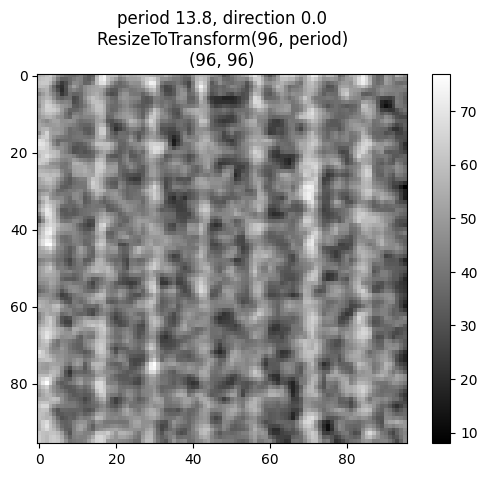

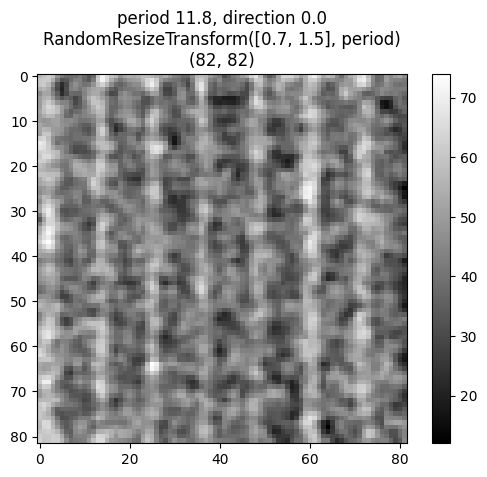

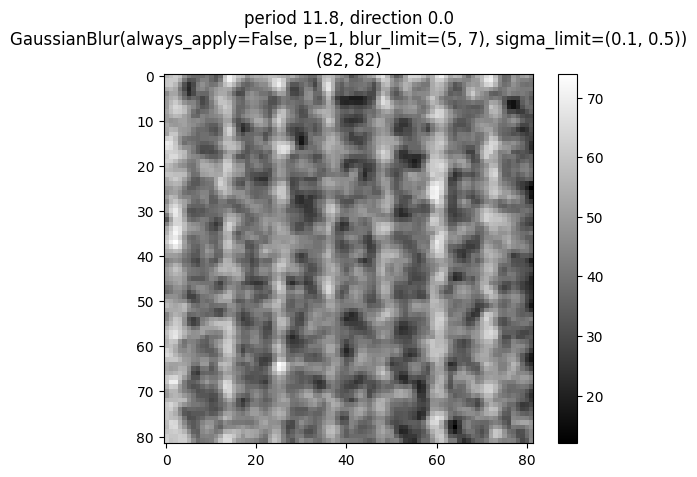

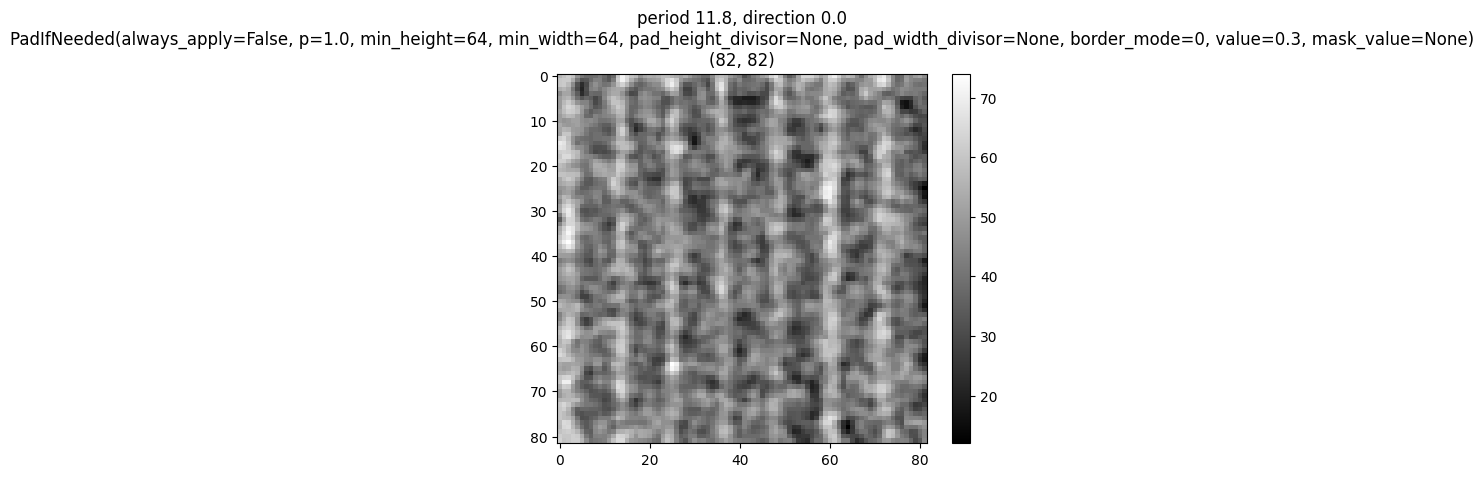

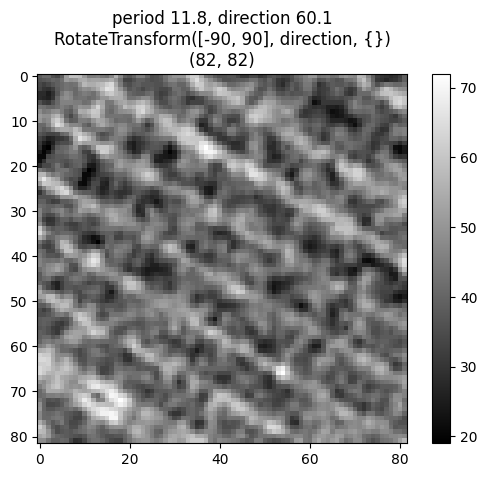

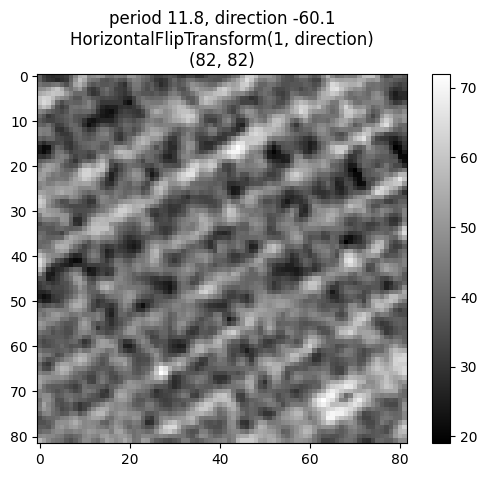

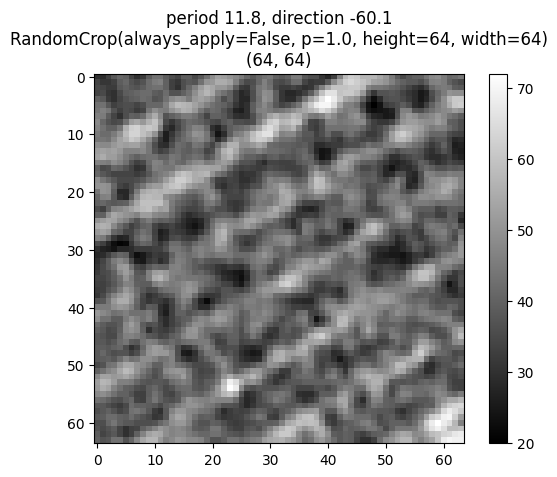

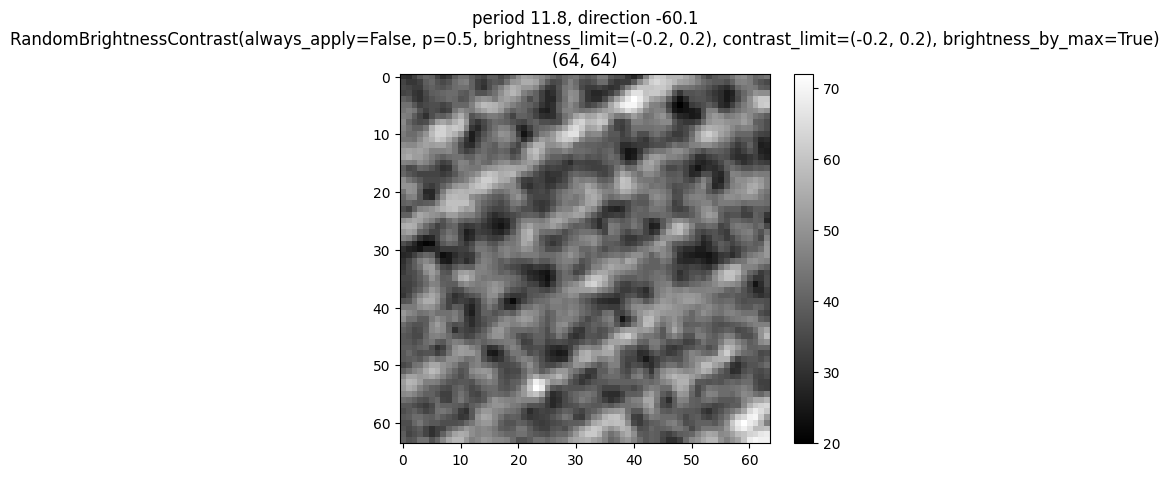

In [21]:
idx = 200
input = ds_raw[idx] #{'image_path': str(anns.iloc[idx]['img_path'], 'period': annotations.iloc[idx]['period'], 'direction': annotations.iloc[idx]['direction']-90}

# [ReadImage(mode=cv2.IMREAD_GRAYSCALE)] + 
for transform in train_transforms:
  input = transform(**input)
  img = input['image']
  if isinstance(img, torch.Tensor):
    print(img.shape, img.dtype, img.max(), img.min())
  else:
    plt.figure()
    plt.imshow(input['image'], cmap='gray')
    plt.title(f'period {input["period"]:0.1f}, direction {input["direction"]:0.1f}\n{transform}\n{img.shape}')
    plt.colorbar()

## Data generation

### prepare datasets

In [12]:
ds_train = StripsDataset(anns.iloc[:60000].reindex(), data_root=data_dir, transforms=train_transforms)
ds_val = StripsDataset(anns.iloc[60000:].reindex(), data_root=data_dir, transforms=test_transforms)


In [22]:
entry = ds_train[0]
img = entry.pop('image')
target = {k: v.item() for k, v in entry.items()}

In [23]:
img

array([[54, 58, 59, ..., 66, 71, 76],
       [57, 59, 59, ..., 65, 70, 68],
       [58, 62, 61, ..., 62, 68, 66],
       ...,
       [63, 64, 61, ..., 52, 49, 52],
       [62, 62, 62, ..., 61, 60, 60],
       [55, 54, 59, ..., 67, 68, 66]], dtype=uint8)

In [24]:
target

{'period': 26.780561447143555,
 'white_fraction': 0.656680166721344,
 'direction': 82.2479248046875}

### prepare directory structure

In [26]:
output_main_dir = Path('/scratch/projects/023/01_data/synthetic/001_processed')
output_train_images_dir = output_main_dir / 'train' / 'images'
output_train_labels_dir = output_main_dir / 'train' / 'labels'
output_test_images_dir = output_main_dir / 'test' / 'images'
output_test_labels_dir = output_main_dir / 'test' / 'labels'
for d in [output_train_images_dir, output_train_labels_dir, output_test_images_dir, output_test_labels_dir]:
    d.mkdir(exist_ok=True, parents=True)

### generate data

#### train data

In [42]:
train_multpication = 20

In [44]:
i_item= 0
for epoch in range(train_multpication):
    for i in range(len(ds_train)):
        entry = ds_train[i]
        img = entry.pop('image')
        target = {k: v.item() for k, v in entry.items()}
        np.save(output_train_images_dir / f'{i_item:06d}.npy', img)
        with open(output_train_labels_dir / f'{i_item:06d}.json', 'w') as f:
            json.dump(target, f)
        i_item += 1
    

#### test data

In [45]:
test_multpication = 1

In [48]:
i_item= 0
for epoch in range(test_multpication):
    for i in range(len(ds_val)):
        entry = ds_val[i]
        img = entry.pop('image')
        target = {k: v.item() for k, v in entry.items()}
        np.save(output_test_images_dir / f'{i_item:06d}.npy', img)
        with open(output_test_labels_dir / f'{i_item:06d}.json', 'w') as f:
            json.dump(target, f)
        i_item += 1
    

## Model

In [13]:
from pytorch_lightning.loggers import NeptuneLogger, TensorBoardLogger

In [14]:
class StripsModel(pl.LightningModule):
  def __init__(self, 
               model_name = 'resnet18',
               optimizer_hparams=dict(lr=0.001),
               lr_hparams=dict(classname='MultiStepLR', kwargs=dict(milestones=[100, 150], gamma=0.1)), 
               loss_hparams=dict(rotation_weight=10., white_frac_weight=50.),
               ):
    super().__init__()
    # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
    self.save_hyperparameters()
    # Create model
    self.model =  timm.create_model(model_name, in_chans=1, num_classes=4) #sin, cos, period, white frac
    # classifier = list(self.model.children())[-1]
    # try:
    #     torch.nn.init.zeros_(classifier.weight)
    #     torch.nn.init.constant_(classifier.bias, 25)
    # except:
    #     pass
    self.losses = {
        'direction': CosineLoss(1., True),
        'period': torch.nn.functional.mse_loss,
        'white_fraction': torch.nn.functional.mse_loss
    }
    self.losses_weights = {
      'direction': self.hparams.loss_hparams['rotation_weight'],
      'period': 1,
      'white_fraction': self.hparams.loss_hparams['white_frac_weight'],
    }
    # Create loss module
    # self.loss_module = torch.nn.MSELoss(reduction='none')
  def configure_optimizers(self):
    # AdamW is Adam with a correct implementation of weight decay (see here
    # for details: https://arxiv.org/pdf/1711.05101.pdf)
    optimizer = torch.optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
    scheduler = getattr(torch.optim.lr_scheduler, self.hparams.lr_hparams['classname'])(optimizer, **self.hparams.lr_hparams['kwargs'])
    return [optimizer], [scheduler]

  def forward(self, x):
    """get predictions from image batch"""
    preds = self.model(x) # preds: angle_sin, angle_cos, period, white fraction
    preds_sin = 1. - 2*torch.sigmoid(preds[:,0])
    preds_cos = 1. - 2*torch.sigmoid(preds[:,1])
    preds_direction = torch.rad2deg(torch.arctan2(preds_sin, preds_cos)) * 0.5 # arctan2 covers 360 degress. Since we need to cover 180 degrees, it is divided by 2
    preds_period = preds[:,2]
    preds_white_frac = torch.sigmoid(preds[:,3]) #white fraction is between 0 and 1, so we take sigmoid fo this
    return preds_direction, preds_period, preds_white_frac

  def process_batch_supervised(self, batch):
    """get predictions, losses and mean errors (MAE)"""

    # get predictions
    preds = {}
    preds['direction'], preds['period'], preds['white_fraction'] = self.forward(batch['image']) # preds: angle, period, white fraction

    # calculate losses
    losses = {
        'direction': self.losses_weights['direction'] * self.losses['direction'](2*batch['direction'], 2*preds['direction']),
        'period': self.losses_weights['period'] * self.losses['period'](batch['period'], preds['period']),
        'white_fraction': self.losses_weights['white_fraction'] * self.losses['white_fraction'](batch['white_fraction'], preds['white_fraction']),
    }
    losses['final'] = losses['direction'] + losses['period'] + losses['white_fraction']

    # calculate mean errors
    period_difference = np.mean(abs(
      batch['period'].detach().cpu().numpy() - \
      preds['period'].detach().cpu().numpy()
    ))

    a1 = batch['direction'].detach().cpu().numpy()
    a2 = preds['direction'].detach().cpu().numpy()
    angle_difference = np.mean(0.5*np.degrees(np.arccos(np.cos(2*np.radians(a2-a1)))))

    white_frac_difference = np.mean(abs(preds['white_fraction'].detach().cpu().numpy()-batch['white_fraction'].detach().cpu().numpy()))

    mae = {
      'period': period_difference,
      'direction': angle_difference,
      'white_fraction': white_frac_difference
    }

    return preds, losses, mae

  def log_all(self, losses, mae, prefix=''):
    self.log(f"{prefix}angle_loss", losses['direction'].item())
    self.log(f"{prefix}period_loss", losses['period'].item())
    self.log(f"{prefix}white_fraction_loss", losses['white_fraction'].item())
    self.log(f"{prefix}period_difference", mae['period'])
    self.log(f"{prefix}angle_difference", mae['direction'])
    self.log(f"{prefix}white_fraction_difference", mae['white_fraction'])
    self.log(f"{prefix}loss", losses['final'])
  
  def training_step(self, batch, batch_idx):
    # "batch" is the output of the training data loader.
    preds, losses, mae = self.process_batch_supervised(batch)
    self.log_all(losses, mae, prefix='train_')

    return losses['final'] 
  
  def validation_step(self, batch, batch_idx):
    preds, losses, mae = self.process_batch_supervised(batch)
    self.log_all(losses, mae, prefix='val_')
  
  def test_step(self, batch, batch_idx):
    preds, losses, mae = self.process_batch_supervised(batch)
    self.log_all(losses, mae, prefix='test_')

In [15]:
num_workers = 16
batch_size = 80

print(len(anns))
anns_sample = anns.sample(frac=1) #anns.sample(15000) #shuffle 

ds_train = StripsDataset(anns_sample.iloc[:60000].reindex(), data_root=data_dir, transforms=train_transforms)
ds_val = StripsDataset(anns_sample.iloc[60000:].reindex(), data_root=data_dir, transforms=test_transforms)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, num_workers=num_workers)

81600


In [16]:
for batch in dl_train:
    break

In [17]:
# white_frac_weight = 10.

# model =  timm.create_model(model_name, in_chans=1, num_classes=3) #angle, period, white_fraction

# losses = {
#     'direction': CosineLoss(1., True, scale=loss_hparams['rotation_loss_scale']),
#     'period': torch.nn.functional.mse_loss,
#     'white_fraction': torch.nn.functional.mse_loss
# }

# preds = model(batch['image']) # angle, period
    
# direction_loss = losses['direction'](2*batch['direction'], 2*preds[:,0])
# period_loss = losses['period'](batch['period'], preds[:,1])
# white_frac_loss = losses['white_fraction'](batch['white_fraction'], preds[:,2])
# loss = direction_loss + period_loss + white_frac_weight * white_frac_loss


In [18]:
batch.keys()

dict_keys(['image', 'period', 'white_fraction', 'direction'])

In [19]:
batch['direction']

tensor([ 4.6630e-01,  7.3739e+01,  5.2280e+01,  8.5122e+01, -6.4115e+00,
        -5.0413e+00, -4.5562e+01, -5.6792e+01, -4.7901e+01,  5.7239e+01,
         8.3234e+01, -7.7957e+00, -7.6054e+01,  4.5630e+01, -2.8827e+01,
         5.1726e+01,  1.3965e+01, -3.4419e+00,  3.1970e+01, -8.5374e+01,
        -5.9670e+01, -6.7145e+01, -2.5845e+01, -4.5794e+01,  5.5756e+01,
        -6.3540e+01, -8.0313e+01,  7.8033e+01,  8.8701e+00,  4.0057e+01,
         1.7297e+01,  4.7815e+01,  7.4604e+01, -8.4601e+01,  5.2143e+01,
         5.9305e+01,  1.8962e+00,  3.9446e+00, -3.3396e+01, -7.2944e+01,
         8.0185e+01,  2.3242e+01, -6.8710e+01,  7.6666e+00,  5.5969e+01,
        -1.9151e+01, -3.1855e+01, -2.5161e-02,  2.6398e+01, -3.6290e+00,
         5.0365e+01, -1.5322e+01,  5.4187e+01,  6.2376e+00,  6.9242e+00,
        -6.9934e+01, -2.4395e+01, -3.5199e+01, -7.0291e+01,  6.9187e+01,
        -6.7653e+01,  3.9709e+01, -7.9805e+01, -2.8864e+00,  1.2239e+01,
         8.5839e+01,  6.3019e+01, -7.5021e+01, -6.3

In [20]:
model_name = 'mobilenetv3_small_050' # 'mobilenetv3_small_050' (fast), 'tinynet_e' (fast), 'lcnet_050' (fast), 'resnet10t' (fast), 'resnet18', 'convnext_atto', 'cs3darknet_focus_s', 'mixer_s32_224'
optimizer_hparams = dict(lr=0.001)
lr_hparams=dict(classname='CosineAnnealingLR', kwargs=dict(T_max=50, eta_min=0.0001)) #dict(milestones=[170, 250], gamma=0.25),
loss_hparams=dict(rotation_weight=100., white_frac_weight=1000.)

num_epochs = 50

In [21]:
use_neptune_logger = True

loggers = [TensorBoardLogger(save_dir='.')] 
if use_neptune_logger:
    neptune_logger = NeptuneLogger(
        api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkYjhjYzFiYi02OGEyLTRhYzMtOWMzMS1kMDc1OGFiMzgwMjcifQ==",
        project='UWCenter4ML/023-strips-synthetic',
        tags=['test_run', f'size_{len(anns_sample)}', 'direction', 'period'],
        log_model_checkpoints=True,
    )
    loggers.append(neptune_logger)    

In [22]:
trainer = pl.Trainer(
        # default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        accelerator='gpu',
        precision='16-mixed',
        # How many epochs to train for if no patience is set
        max_epochs=num_epochs,
        log_every_n_steps=1,
        gradient_clip_val=1,
        logger = loggers,
        callbacks=[
            pl.callbacks.ModelCheckpoint(
                save_weights_only=True, mode="min", monitor="val_loss", save_top_k=3
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            pl.callbacks.LearningRateMonitor("epoch"),
            # pl.callbacks.DeviceStatsMonitor(cpu_stats=True), # statystyki procesora itp - bardzo duzo
        ],  # Log learning rate every epoch
        # progress_bar_refresh_rate=1,
        profiler=pl.profilers.PyTorchProfiler(filename="profiler_output"), #"simple"
    )

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
pl_model = StripsModel(
    optimizer_hparams = optimizer_hparams,
    model_name = model_name,
    lr_hparams = lr_hparams,
    loss_hparams = loss_hparams
    )

In [24]:
# pl_model.training_step(batch, 0)

In [25]:
# batch = next(iter(dl_train))
# pl_model.training_step(batch, 0)

In [26]:
# (neptune) log hyper-parameters
if use_neptune_logger:
    neptune_logger.log_hyperparams(params={
        **pl_model.hparams,
        'transforms_config': transforms_config,
        'data_train_transform': repr(train_transforms),
        'data_test_transform': repr(test_transforms)
        })
try:
    trainer.fit(pl_model, dl_train, dl_val)
except Exception as e:
    print(e)
finally:
    if use_neptune_logger:
        neptune_logger.run.stop()

/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/loggers/neptune.py:358: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  self._run_instance = neptune.init_run(**self._neptune_init_args)
/home/jupyter/.local/lib/python3.10/site-packages/neptune/internal/utils/git.py:56: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


https://app.neptune.ai/UWCenter4ML/023-strips-synthetic/e/SYNTH-55


/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/loggers/neptune.py:406: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  self.run[parameters_key] = params
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | Effic

Sanity Checking: 0it [00:00, ?it/s]

STAGE:2023-06-06 12:43:07 459166:459166 ActivityProfilerController.cpp:294] Completed Stage: Warm Up


Training: 0it [00:00, ?it/s]

STAGE:2023-06-06 12:43:09 459166:459166 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:436] Warning: [pl][profile][LightningModule]StripsModel.optimizer_step (function operator())
STAGE:2023-06-06 12:43:10 459166:459166 output_json.cpp:417] Completed Stage: Post Processing


Validation: 0it [00:00, ?it/s]

STAGE:2023-06-06 12:43:32 459166:459166 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-06-06 12:43:32 459166:459166 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-06-06 12:43:32 459166:459166 output_json.cpp:417] Completed Stage: Post Processing


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 21 operations to synchronize with Neptune. Do not kill this process.
All 21 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/UWCenter4ML/023-strips-synthetic/e/SYNTH-55/metadata


In [27]:
# torch.set_float32_matmul_precision('medium')

In [28]:
# neptune_logger.run.stop()

In [29]:
# torch._C._cuda_init()

In [30]:
angles = (torch.rand(10) -0.5)* 2*3.1415
sins, coss = torch.sin(angles), torch.cos(angles) 

In [31]:
angles_pred = torch.arctan2(sins, coss)

In [32]:
angles

tensor([-1.9012, -2.1875, -0.3238, -2.6172, -1.5725,  1.1803,  1.2495,  0.3503,
         0.2038,  0.7927])

In [33]:
angles_pred

tensor([-1.9012, -2.1875, -0.3238, -2.6172, -1.5725,  1.1803,  1.2495,  0.3503,
         0.2038,  0.7927])

In [34]:
torch.rad2deg

<function torch._VariableFunctionsClass.rad2deg>